<h1 align=center><font size=5>Neural Network from scratch. Run over MINST Dataset  </font></h1>

In this notebook we implement a Neural Network (NN) form sratch and test this implementation by training it with the MINST dataset.

This is a simple NN implementation whose aim is to explain in a simple manner how the internal details of NN's work. Therefore some issues such as vanishing gradient are not treated here. The same applies for some features like batch normallization, dropput, gradient descent with momentum, etc.

Althoug this is a very rudimentary implementation. It performs very good in the MINST sataset achiving over 96% accuracy on newly seen samples after 3000 iterations of training.

In [1]:
#Needed libraries and modules
import pandas as pd                                  # data processing, reading CSV file, dealing with dataframes etc
import numpy as np                                   # linear algebra functionalities 
import seaborn as sns                                # visualization library
import matplotlib.pyplot as plt                      # visualization library

#Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import math 
import time
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

### Table of Contents

* [1. Functions required to build a deep NN ](#Section1)
    * [1.1 Initialize the parameters](#SubSection_1_1)
    * [1.2 Implement forward propagation](#SubSection_1_2)
    * [1.3 Compute loss](#SubSection_1_3)
    * [1.4 Implement backward propagation](#SubSection_1_4)
    * [1.5 Update the parameters](#SubSection_1_5)
    * [1.6 Putting all together](#SubSection_1_5)
* [2. Testing implementation on MINST Dataset ](#Section2)
    * [2.1 Loading and checking the data](#SubSection_2_1)
    * [2.2 Training the NN](#SubSection_2_2)



 # 1. Functions required to build a deep NN <a class="anchor" id="Section1"></a>

In this section we build the required functions for a L-layer NN. In particluar, we will:

1. Initialize the paremers 
2. Implement forward propagation
3. Compute loss
4. Implement backward propagation
5. Update the parameters


### 1.1 Initialize the parameters <a class="anchor" id="SubSection_1_1"></a> 

In [2]:
def initialize_parameters_DNN(layers_dims, random_seed = 1, sigma = 0.01):
    """
    Arguments:
    layer_dims -- python array (list) storing the dimensions per layer in the network
    random_seed -- seed for reproducibility
    sigma -- standard deviation of the normal distribution generating the random samples 
    
    Returns:
    parameters -- python dictionary containing the initialized netwrok parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix corresponding to layer l, shape: (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector corresponding to layer l, shape: (layer_dims[l], 1)
    """
    
    np.random.seed(random_seed)
    parameters = {}                 #dictionary to store the parameters once initialized
    L = len(layers_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1])*sigma 
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layers_dims[l], 1))

        
    return parameters

### 1.2 Implement forward propagation <a class="anchor" id="SubSection_1_2"></a> 

We implement forward propagation by means of the following functions:
    
- linear_forward: It computes $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$
- Activation functions: sigmoid, relu
- linear_action_forward: It computes $A^{[l]}=g^{[l]}(W^{[l]}A^{[l-1]} +b^{[l]})$ where $g^{[l]}$ is either ReLU or Sigmoid. 
- Forward propagation for the whole model: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

1. Linear forward 

In [3]:
def linear_forward(A, W, b):
    """
    This is the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data)
    W -- weights matrix
    b -- bias vector

    Returns:
    Z -- the input of the activation function (pre-activation parameter) 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward step in this layer
    """
    
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    return Z, cache

2. Activation functions

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [5]:
def relu(z):
    return np.maximum(0,z)

3. Linear activation forward 

In [6]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    This is the LINEAR->ACTIVATION part of the propagation for the  layer

    Arguments:
    A_prev -- activation from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A = sigmoid(Z)
    if activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A = relu(Z)
    
    activation_cache = Z
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    
    cache = (linear_cache, activation_cache)
    #cache = ((A_prev, W, b), Z)

    return A, cache

4. Forward propagation for the complete model

In [7]:
def L_model_forward(X, parameters):
    """
    Forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- initial data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_DNN()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    #First L-1 stpes with relu activation
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], 'relu')
        caches.append(cache)
        
    
    # Last step with sigmoid activation
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], 'sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (parameters['b'+str(L)].shape[0],X.shape[1]))
            
    return AL, caches

### 1.3 Compute loss <a class="anchor" id="SubSection_1_3"></a> 

We compute the cross-entropy cost $J$: 

$$-\frac{1}{m} \sum\limits_{i = 1}^{m} \sum_{j=1}^{n^{[L]}} \left[y_j^{(i)}\log\left(a_j^{[L] (i)}\right) + (1-y_j^{(i)})\log\left(1- a_j^{[L](i)}\right)\right] $$

We recall that $n^{[L]}$ is the dmension of the output layer, i.e. the amount of classes.

In [8]:
def compute_cost(AL, Y):
    """
    Cost function defined by the above equation

    Arguments:
    AL -- probability matrix corresponding to your label predictions, shape (number of classes, number of examples)
    Y -- true "label" matrix, shape (number of classes, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    cost = (-1/m) * np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    return cost

### 1.4 Backward propagation <a class="anchor" id="SubSection_1_4"></a> 

In the layer $l$, once we have computed the gradient $dZ^{[l]} = \frac{\partial J }{\partial Z^{[l]}}$, we can compute $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ as follows

$$ dW^{[l]} = \frac{\partial {J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} = \frac{\partial {J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial J }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} $$


We thus implement backward propagation by means of the following functions:
    
- linear_backward: Given $dZ^{[l]}$,  it computes $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ 
- Derivatives of the activation functions: sigmoid_der, relu_der
- sigmoid_backward, relu_backward: They compute $dZ^{[l]} = dA^{[l]} * {g^{[l]}}^\prime (Z^{[l]})$, where $*$ denotes element-wise multipliaction, and ${g^{[l]}}$ is the activation function corresponding to the layer l (relo or sigmoid).
- linear_activation_backward: Does the full backward porpagation step in a given layer
- Backward propagation for the whole model: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

1. linear_backward

In [9]:
def linear_backward(dZ, cache):
    """
    This is the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to Z^[l] (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ,A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

2. Derivatives of the activation functions

In [10]:
def sigmoid_der(z):
    a = sigmoid(z)
    return a*(1-a)

In [11]:
def relu_der(z):
    return np.heaviside(z, 1)


3. sigmoid_backward, relu_backward: Given dA, they compute dZ

In [12]:
def sigmoid_backward(dA, activation_cache):
    """
    Arguments:
    dA -- Gradient of the cost with respect to the activation (of current layer l)
    activation_cache -- pre-activation parameter Z in the current layer (obtained from forward propagation)

    Returns:
    dZ -- Gradient of the cost with respect to Z^[l] (of current layer l)
    """
    dZ = dA * sigmoid_der(activation_cache) 
    return dZ

In [13]:
def relu_backward(dA, activation_cache):
    """
    Arguments:
    dA -- Gradient of the cost with respect to the activation (of current layer l)
    activation_cache -- pre-activation parameter Z in the current layer (obtained from forward propagation)

    Returns:
    dZ -- Gradient of the cost with respect to Z^[l] (of current layer l)
    """
    dZ = dA * relu_der(activation_cache) 
    return dZ

4. Backward propagation step in a given layer

In [14]:
def linear_activation_backward(dA, cache, activation):
    """
    Full backward propagation step for a given layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l, i.e. dA^[l] 
    cache -- tuple of values (linear_cache, activation_cache) = ((A^[l-1], W^[l], b^[l]), Z^[l]) 
             we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, cache[1])
        dA_prev, dW, db = linear_backward(dZ, cache[0])
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, cache[1])
        dA_prev, dW, db = linear_backward(dZ, cache[0])
    
    return dA_prev, dW, db

5. Backward propagation for the whole model

In [15]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector in {0,1}^{n^[L]}
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu", i.e. caches[l], for l in range(L-1) i.e. l = 0...L-2 and
                the cache of linear_activation_forward() with "sigmoid", i.e. caches[L-1]
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Step for Lth layer SIGMOID. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, caches[L-1], 'sigmoid')
    
    # Lopp for the rest of layers RELU, l=L-2, ..., 0
    for l in reversed(range(L-1)): 
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads['dA'+str(l+1)], caches[l], 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### 1.5 Update parameters <a class="anchor" id="SubSection_1_5"></a> 

We now update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$


In [16]:
def update_parameters(parameters, grads, learning_rate):
    """
    Arguments:
    parameters -- python dictionary containing the parameters 
    grads -- python dictionary containing the corresponding gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads['dW'+ str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads['db'+ str(l+1)]
    return parameters

### 1.6 Putting all together <a class="anchor" id="SubSection_1_6"></a> 

Now we use the above component functions to define the a prediction function and a fit function for the Neural Network model.

In [17]:
#prediction function

def Digits_NN_predict(X, parameters):
    AL, caches = L_model_forward(X, parameters)
    return np.argmax(AL, axis =0)

In [18]:
def L_layer_NN_fit(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, random_seed=1, sigma=0.01):
    """
    Trains an L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- initial data, numpy array of shape (n^[0], number of examples)
    Y -- true "label" vector (containing 0 in entries representing the incorrect lable, 1 in entries 
         representing the correct lable), of shape (n^[L] = number of classes, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    random_seed -- seed for reproducibility in initialization of the parameters
    sigma -- standard deviation in initialization of the parameters
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """

    np.random.seed(random_seed)
    costs = []                         # keep track of cost
    
    # Parameters initialization
    parameters = initialize_parameters_DNN(layers_dims, random_seed, sigma)
    
    #print("Intial W1 parameter: \n", parameters['W1'])
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
            #print("Gradient W1 after iteration %i: %f \n", grads['dW1'])
            Ytemp = Digits_NN_predict(X, parameters)
            print("Accuracy after iteration " + str(i)+ ':', accuracy_score(Ytemp, True_labels))
            
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()  
   
    
    return parameters

 # 2. Digit Recognition MINST data set NN <a class="anchor" id="Section2"></a>
 
 We will now test our implementation of a neural network using the well-known MINST dataset. 

### 2.1 Loading and checking the data <a class="anchor" id="SubSection_2_1"></a> 

In [19]:
#Loading training and test set to dataframes
path_train = 'train.csv'
path_test = 'test.csv'
path_test_lables = 'test_labels.csv'

df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

True_labels = df_train['label'].to_numpy()
df_test_lables = pd.read_csv(path_test_lables)


In [20]:
df_train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now covert labels to categorizal data to meed the implementation requirements of our model.

In [21]:
#Converting labels into categorical data

Y = pd.get_dummies(df_train["label"])
Y

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
41995,1,0,0,0,0,0,0,0,0,0
41996,0,1,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,1,0,0
41998,0,0,0,0,0,0,1,0,0,0


In [22]:
#Converting train and test sets to numpy arrays
#each column corresponds to a a data sample

#Train set
X_train = df_train.iloc[:, 1:].to_numpy().T  
Y_train = Y.to_numpy().T

#Test set 
X_test = df_test.to_numpy().T
Y_test = df_test_lables.iloc[:, 1].to_numpy()

In [23]:
Y_train

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [24]:
# Standardize data to have feature values between 0 and 1.
X_train = X_train/255.
X_test = X_test/255.

In [25]:
print("Amount of examples in the train set is:", Y_train.shape[1])
print("Amount of different classes of the data:", Y_train.shape[0])
print("Shape of Y in train set is:", Y_train.shape)
print("Shape of X in train set is:", X_train.shape)
print("Shape of the test set is:", X_test.shape)
print("Each example is an image, i.e. a squared matrix of dimemsion:", math.sqrt(X_train.shape[0]))

Amount of examples in the train set is: 42000
Amount of different classes of the data: 10
Shape of Y in train set is: (10, 42000)
Shape of X in train set is: (784, 42000)
Shape of the test set is: (784, 28000)
Each example is an image, i.e. a squared matrix of dimemsion: 28.0


We define de following function to plot images in a grid if nxn picures with their respective lables

In [26]:
import random
#Function to plot n^2 random images in an array of nxn

def PlotingPictures(Data, size1, size2, n, label = [], rand = False):
    """
    This functions plots n^2 images of size (size1 x size2) in a squared grid of order n.
    
    Parameters:
     1. Data: a list of images of order (a*b, k), that stores k images of order (a,b)
     2. size1 and size2: the shape of the images to be dispayed (size1xsize2 = axb)
     3. n: the size of the squared grid in which we will polt the images
     4. label: set of labels for the images (default empty list)
     5. rand: indicates whether we want to display random images or the first n^2 images
    """
    # width, height in inches
    fig = plt.figure(figsize=(1.5*n, 1.5*n))  
    
    if rand:
        #Taking n^2 random indices for the images to be displayed
        sample = random.sample(range(Data.shape[0]), pow(n,2))
    else:
        sample = range(pow(n,2))
    
    for i in range(pow(n,2)):
        #making a sub plot, each sumplot at a time, and ploting the corresponding image
        sub = fig.add_subplot(n, n, i + 1)
        plt.subplots_adjust(hspace = 3/(n))
        if len(label) !=0:
            sub.set_title("Label: " + str(label[sample[i]]))
        sub.imshow(Data[:,sample[i]].reshape(size1,size2), interpolation='nearest', cmap='gray')


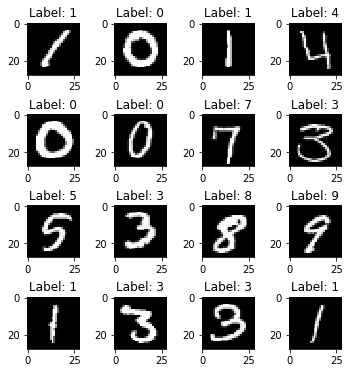

In [27]:
PlotingPictures(X_train, 28, 28, 4, df_train['label'])

### 2.2 Training the NN <a class="anchor" id="SubSection_2_2"></a> 

Cost after iteration 0: 6.931328
Accuracy after iteration 0: 0.11152380952380953
Cost after iteration 100: 3.244564
Accuracy after iteration 100: 0.12480952380952381
Cost after iteration 200: 2.789265
Accuracy after iteration 200: 0.2897857142857143
Cost after iteration 300: 1.944114
Accuracy after iteration 300: 0.5616428571428571
Cost after iteration 400: 1.210278
Accuracy after iteration 400: 0.787547619047619
Cost after iteration 500: 0.849425
Accuracy after iteration 500: 0.8625952380952381
Cost after iteration 600: 0.625139
Accuracy after iteration 600: 0.9021904761904762
Cost after iteration 700: 0.524292
Accuracy after iteration 700: 0.9193571428571429
Cost after iteration 800: 0.459878
Accuracy after iteration 800: 0.928952380952381
Cost after iteration 900: 0.415921
Accuracy after iteration 900: 0.9363333333333334
Cost after iteration 1000: 0.372716
Accuracy after iteration 1000: 0.9430952380952381
Cost after iteration 1100: 0.343332
Accuracy after iteration 1100: 0.948428571

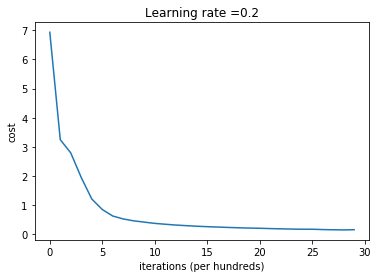

End of training process. Execution time: 715.9088997840881 seconds


In [28]:
layers_dims = [784, 28, 28, 10] #  3-layer model

import time
start_time = time.time()
Trained_params = L_layer_NN_fit(X_train, Y_train, layers_dims, learning_rate = 0.2, 
                                num_iterations = 3000, print_cost=True, random_seed = 7)
print(f'End of training process. Execution time: {(time.time() - start_time)} seconds')


We now check the first 16 predictions in the train set to see that they are indeed correct

First 16 predictions: [1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1]


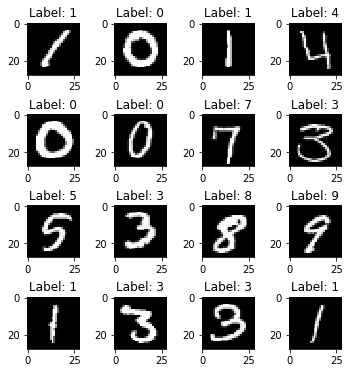

In [29]:
predictions = Digits_NN_predict(X_train, Trained_params)
print(f'First 16 predictions: {predictions[0:16]}') 
PlotingPictures(X_train, 28, 28, 4, df_train['label'])

In [30]:
print(f'Acurracy on the train set: {accuracy_score(predictions, True_labels)}')

Acurracy on the train set: 0.9822619047619048


Let's now check the first 16 predictions in the test set

First 16 predictions: [2 0 9 9 3 7 0 3 0 3 5 7 4 0 4 3]


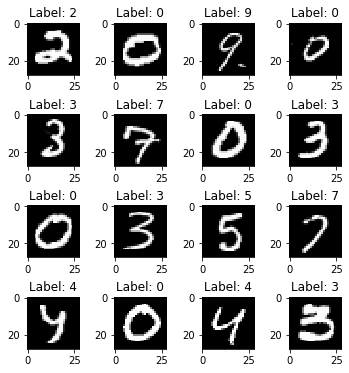

In [31]:
predictions_test = Digits_NN_predict(X_test, Trained_params)
print(f'First 16 predictions: {predictions_test[0:16]}') 
PlotingPictures(X_test, 28, 28, 4, df_test_lables["Label"])

We see that only in the fourth picture we have a misclassification: "9 instead of 0"

In [32]:
print(f'Acurracy on the train set: {accuracy_score(predictions_test, Y_test)}')
print(f'Amount of missclassified samples: {sum(predictions_test != Y_test)}')

Acurracy on the train set: 0.9615714285714285
Amount of missclassified samples: 1076


Let's now see some examples of missclassified pictures. The labels used are the ones of the prediction. 

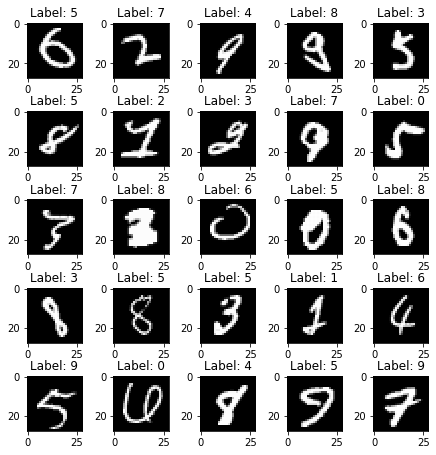

In [33]:
misclassified = predictions_test != Y_test
PlotingPictures(X_test[:,misclassified], 28, 28, 5, predictions_test[misclassified], rand = True)